# 书写优化器代码

神经网络中的优化算法几乎都是与梯度挂钩, 无外乎梯度下降的变种, 以及L-BFGS等

### Momentum
单纯的梯度下降容易在梯度为零处卡住, 比如低维的局部极值点,高维鞍点, 模型的收敛往往取决于初始点的选取

带动量的梯度下降相当于一种平滑处理, 机制为ExponentialMovingAverage, 梯度的更新量需要考虑过去值, 

当到达极值点时, 梯度会带有以往的势能, 在一定程度上能跨过局部最小

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 1000)

y = lambda x:((x+1)**2+4) * (x<0) + (x>=0) * (4*(x-1)**2+1)
plt.scatter([-1,1], [4,1], c='r') # 极值点
plt.plot(x, y(x));

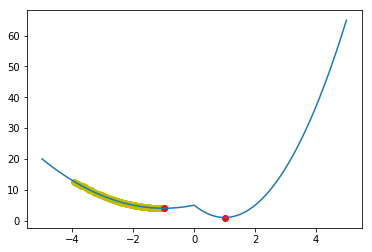

In [2]:
x0 = -4
lr = 0.01

def partial(x):
    if x == 0:
        raise ValueError('不可导')
    dx = (2*(x+1)) * (x<0) + (8*(x-1)) * (x>0)
    return dx

for i in range(10000):
    x0 -= lr * partial(x0)
    plt.scatter(x0, y(x0), c='y')
    
plt.scatter([-1,1], [4,1], c='r') # 极值点    
plt.plot(x, y(x));

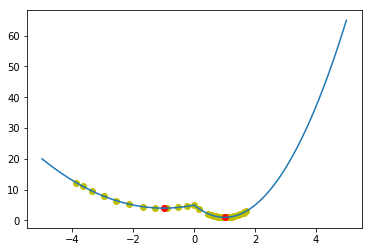

In [3]:
import copy

x0 = -4
lr = 0.2
alpha = 0.1
# 函数没选好, 梯度太小了, 动量不足, 懒得改
dx_old = 0
for i in range(100):
    dx = alpha * partial(x0) + dx_old * (1-alpha)
    x0 -= lr * dx
    plt.scatter(x0, y(x0), c='y')
    
    dx_old = copy.copy(dx)
    
plt.scatter([-1,1], [4,1], c='r') # 极值点    
plt.plot(x, y(x));

### Ada自适应梯度调节法
Adagrad使用了二阶梯度, 每个参数的更新的learning_rate都不同

在梯度下降的公式基础上, 给learning_rate的乘积项添加了一个乘子, 由梯度的累计均方根和一个防止分母为零的常数因子组成
$$\gamma_k = \sum_{i=1}^{k}\nabla \theta_i^2 \\ \theta_k = \theta_{k-1} - \frac{lr}{\sqrt{\gamma_k}+\epsilon}\nabla \theta_k$$

### RMSProp
RMSProp则是对Adagrad进行了EMA, 
$$\gamma_k = \alpha \gamma_{k-1} + (1 - \alpha) \nabla \theta_k \\ \theta_k = \theta_{k-1} - \frac{lr}{\sqrt{\gamma_k}+\epsilon}\nabla \theta_k$$

### Adam 
Adam结合了一阶与二阶梯度的EMA
$$m_t = \beta_1 m_{t-1} + (1 - \beta_1)\nabla \theta_t \\ v_t = \beta_2 v_{t-1} + (1-\beta_2)\nabla\theta^2_t$$
然后对求出的一二阶乘子进行偏差修正, 修正系数为$\frac{1}{1-\beta_i^t}$
$$\hat{m_t} = \frac{m_t}{1-\beta_1} \\ \hat{v_t} = \frac{v_t}{1-\beta_2}$$
参数更新
$$\theta_t = \theta_{t-1} - lr  \frac{\hat{m_t}}{\sqrt{\hat{v_t}}+\epsilon}$$

### PyTorch种优化器选择

In [1]:
from sklearn.datasets import make_classification
data = make_classification(n_samples=1000, n_features=20,)

In [2]:
import torch as t

x = t.from_numpy(data[0]).float()
x.requires_grad = True
y_ = t.from_numpy(data[1]).float()

In [3]:
class MLP(t.nn.Module):
    def __init__(self, 
                 num_classes=10):
        super(MLP, self).__init__()
        self.linear1 = t.nn.Linear(in_features=20, out_features=32)
        self.bn1 = t.nn.BatchNorm1d(32)
        self.linear2 = t.nn.Linear(32,64)
        self.bn2 = t.nn.BatchNorm1d(64)
        self.linear3 = t.nn.Linear(64,1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = t.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.linear3(x)
        x = t.sigmoid(x)
        return x


In [6]:
criterion = t.nn.BCELoss()

models = []
for i in range(5):
    models.append(MLP())
opt1 = t.optim.SGD(models[0].parameters(), lr=1e-3)
opt2 = t.optim.Adagrad(models[1].parameters(), lr=1e-3)
opt3 = t.optim.RMSprop(models[2].parameters(), lr=1e-3)
opt4 = t.optim.Adam(models[3].parameters(), lr=1e-3)
opt5 = t.optim.SGD(models[4].parameters(), lr=1e-3, momentum=0.9)
opts = [opt1, opt2, opt3, opt4, opt5]

In [7]:
losses = []
for i, opt in enumerate(opts):
    
    losses.append([])
    for epoch in range(100):
        opt.zero_grad()
        
        y = models[i](x)
        
        loss = criterion(y.squeeze(), y_)
        loss.backward()
        
        opt.step()
        losses[i].append(loss.data.item())
        

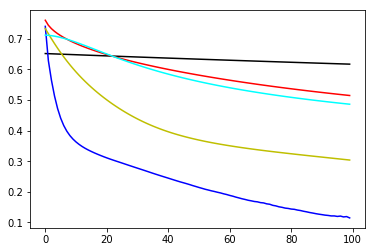

In [22]:
import matplotlib.pyplot as plt
cmap = ['k', 'r', 'b','y','cyan']
for loss, c in zip(losses, cmap):
    plt.plot(range(100), loss, c=c)